In [1]:
import gymnasium as gym
from gymnasium.wrappers import TimeLimit, TransformReward
from collections import defaultdict
from collections.abc import Mapping
from typing import Any, Optional, Union
import numpy as np
from itertools import count
from collections import Counter
import matplotlib.pyplot as plt
import moving_firefighter_env as mfp
import math

In [2]:
class LinearAnnealer:
    def __init__(self, start_value, end_value, total_steps):
        self.start_value = start_value
        self.end_value = end_value
        self.total_steps = total_steps
        self.current_step = 0

    def step(self) -> float:
        if self.current_step >= self.total_steps:
            return self.end_value
        else:
            value = self.__call__()
            self.current_step += 1
            return value

    def __call__(self):
        return self.start_value - (self.start_value - self.end_value) * (self.current_step / self.total_steps)

In [3]:
class EpsilonGreedy:
    def __init__(self,
        env: Union[gym.Env, gym.Wrapper],
        epsilon: float,
        q: np.ndarray, 
        guided: bool = True):
        
        self.epsilon = epsilon
        self.env = env
        self.Q = q
        self.guided = guided

    def __call__(self, state: int) -> float:
        if np.random.random() < self.epsilon:
            if self.guided:
                return np.random.choice(env.unwrapped.valid_actions())
            else:
                return self.env.action_space.sample()
        else:
            actions = []
            max_q_value = float("-inf")
            for action in env.unwrapped.valid_actions():
                q_value = self.Q[state, action]
                if q_value > max_q_value:
                    max_q_value = q_value
                    actions = [action]
                elif q_value == max_q_value:
                    actions.append(action)
            return np.random.choice(actions)

    def action_probs(self, state):
        probs = np.ones(self.env.action_space.n) * (self.epsilon / env.action_space.n)
        probs[np.argmax(self.Q[state, :])] += 1 - self.epsilon
        return probs

In [4]:
class Greedy:
    def __init__(self, q: np.ndarray):
        self.Q = q

    def __call__(self, state: int) -> float:
        return np.argmax(self.Q[state, :])

In [5]:
def SARSA(
    env: Union[gym.Env, gym.Wrapper],
    alpha: float,
    gamma: float,
    epsilon_annealer: LinearAnnealer,
    episodes: int):

    obs_dim = env.action_space.n + 1 # our observation space is the node space
    actions_dim = env.action_space.n + 1

    Q = np.zeros((obs_dim, actions_dim))
    rewards = np.zeros(episodes)
    for i in range(episodes):
        policy = EpsilonGreedy(env, epsilon_annealer(), Q)
        done = False

        state, _ = env.reset()
        current_node = state["fighter_pos"]
        action = policy(current_node)
        episode_reward = 0
        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_node = next_state["fighter_pos"]
            next_action = policy(next_node)
                
            Q[current_node, action] += alpha * (reward + gamma * Q[next_node, next_action] - Q[current_node, action])
            current_node, action = next_node, next_action
            done = terminated or truncated
            episode_reward += reward
        epsilon_annealer.step()
        rewards[i] = episode_reward
    return Greedy(Q), rewards

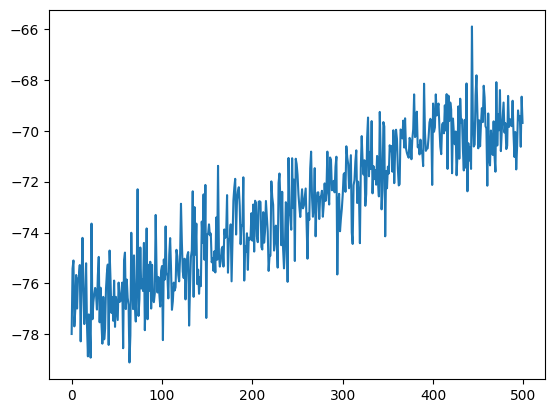

In [15]:
slippery = False
episodes = 500
experiments = 100

global_rewards = np.zeros(episodes)
for _ in range(experiments):
    env = gym.make("mfp/MovingFirefighter-v0", n=50, is_tree=False)
    policy, rewards = SARSA(env, 0.1, 0.9, LinearAnnealer(1.0, 0.1, int(episodes * 0.8)), episodes)
    global_rewards += rewards
plt.plot(global_rewards / experiments)